### Load Data

In [32]:
import os
import numpy as np
import pandas as pd
from PIL import Image

csv_path, csv_test_path = "./data/train.csv", "./data/test.csv"
img_dir, img_dir_test = "./data/train_ims", "./data/test_ims"

data_train = pd.read_csv(csv_path)
print(data_train)
data_test = pd.read_csv(csv_test_path)

X_train, y_train, X_test, y_test = [], [], [], []

for _, row in data_train.iterrows():
    img_path = os.path.join(img_dir, row.iloc[0])
    label = int(row.iloc[1])
    img = Image.open(img_path).convert("RGB")
    img = np.array(img).flatten()
    X_train.append(img)
    y_train.append(label)

for _, row in data_test.iterrows():
    img_path = os.path.join(img_dir_test, row.iloc[0])
    label = int(row.iloc[1])
    img = Image.open(img_path).convert("RGB")
    img = np.array(img).flatten()
    X_test.append(img)
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

           im_name  label
0      000231c.jpg      2
1      0002574.jpg      5
2      00027d5.jpg      7
3      000304e.jpg      3
4      00047fc.jpg      7
...            ...    ...
49995  d507197.jpg      5
49996  d508429.jpg      1
49997  d508cb7.jpg      9
49998  d509167.jpg      3
49999  d509c42.jpg      3

[50000 rows x 2 columns]


### Global Parameters

In [33]:
SEED = 42
PCA_N_COMPONENTS = 200

### Size of dataset

In [34]:
print("The shape of the training set (after flatten 3 * 32 * 32): ", X_train.shape)
print("The shape of the testing set (after flatten 3 * 32 * 32): ", X_test.shape)
print("The size of the label of the training set: ", y_train.shape)
print("The size of the label of the test set: ", y_test.shape)

The shape of the training set (after flatten 3 * 32 * 32):  (50000, 3072)
The shape of the testing set (after flatten 3 * 32 * 32):  (10000, 3072)
The size of the label of the training set:  (50000,)
The size of the label of the test set:  (10000,)


### Calculate the number of the labels of each class

In [35]:
# Count the labels
count_labels = np.unique(y_train, return_counts=True)

# Create DataFrame
label_counts_df = pd.DataFrame({
    "Label": count_labels[0],
    "Count": count_labels[1]
}).set_index("Label")

# Print DataFrame
print("Count of each label:")
print(label_counts_df)

Count of each label:
       Count
Label       
0       5038
1       5016
2       5032
3       4991
4       4982
5       4967
6       4985
7       4998
8       5002
9       4989


### Draw Counts

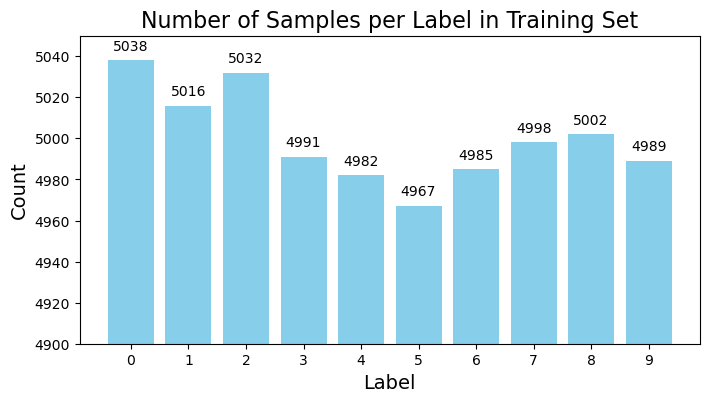

In [36]:
import matplotlib.pyplot as plt

unique_labels = np.unique(y_train)

plt.figure(figsize=(8, 4))
plt.bar(count_labels[0], count_labels[1], color='skyblue')
plt.title("Number of Samples per Label in Training Set", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.ylim([4900, 5050])
plt.xticks(unique_labels)

for i, count in enumerate(count_labels[1]):
    plt.text(count_labels[0][i], count + 5, str(count), ha='center', fontsize=10)

plt.show()

In [37]:
print("Other Statistics for the training set:")
print(pd.Series(y_train).describe())

Other Statistics for the training set:
count    50000.00000
mean         4.49258
std          2.87539
min          0.00000
25%          2.00000
50%          4.00000
75%          7.00000
max          9.00000
dtype: float64


### Visualization_html

In [38]:
from IPython.core.display import HTML

# Count the labels
count_labels = np.unique(y_train, return_counts=True)

# Create DataFrame
label_counts_df = pd.DataFrame({
    "Label": count_labels[0],
    "Count": count_labels[1]
}).set_index("Label")

# Add a column for example images
def get_example_images(label, num_examples=10):
    indices = np.where(y_train == label)[0]
    selected_indices = np.random.choice(indices, size=min(num_examples, len(indices)), replace=False)
    example_images = [os.path.join(img_dir, data_train.iloc[i, 0]) for i in selected_indices]
    return " ".join([f'<img src="{img}" width="50" />' for img in example_images])

label_counts_df["Example Images"] = label_counts_df.index.map(get_example_images)

# Display the DataFrame with images
HTML(label_counts_df.to_html(escape=False))

,Count,Example Images
Label,,
0,5038,
1,5016,
2,5032,
3,4991,
4,4982,
5,4967,
6,4985,
7,4998,
8,5002,


### Visualization_plt

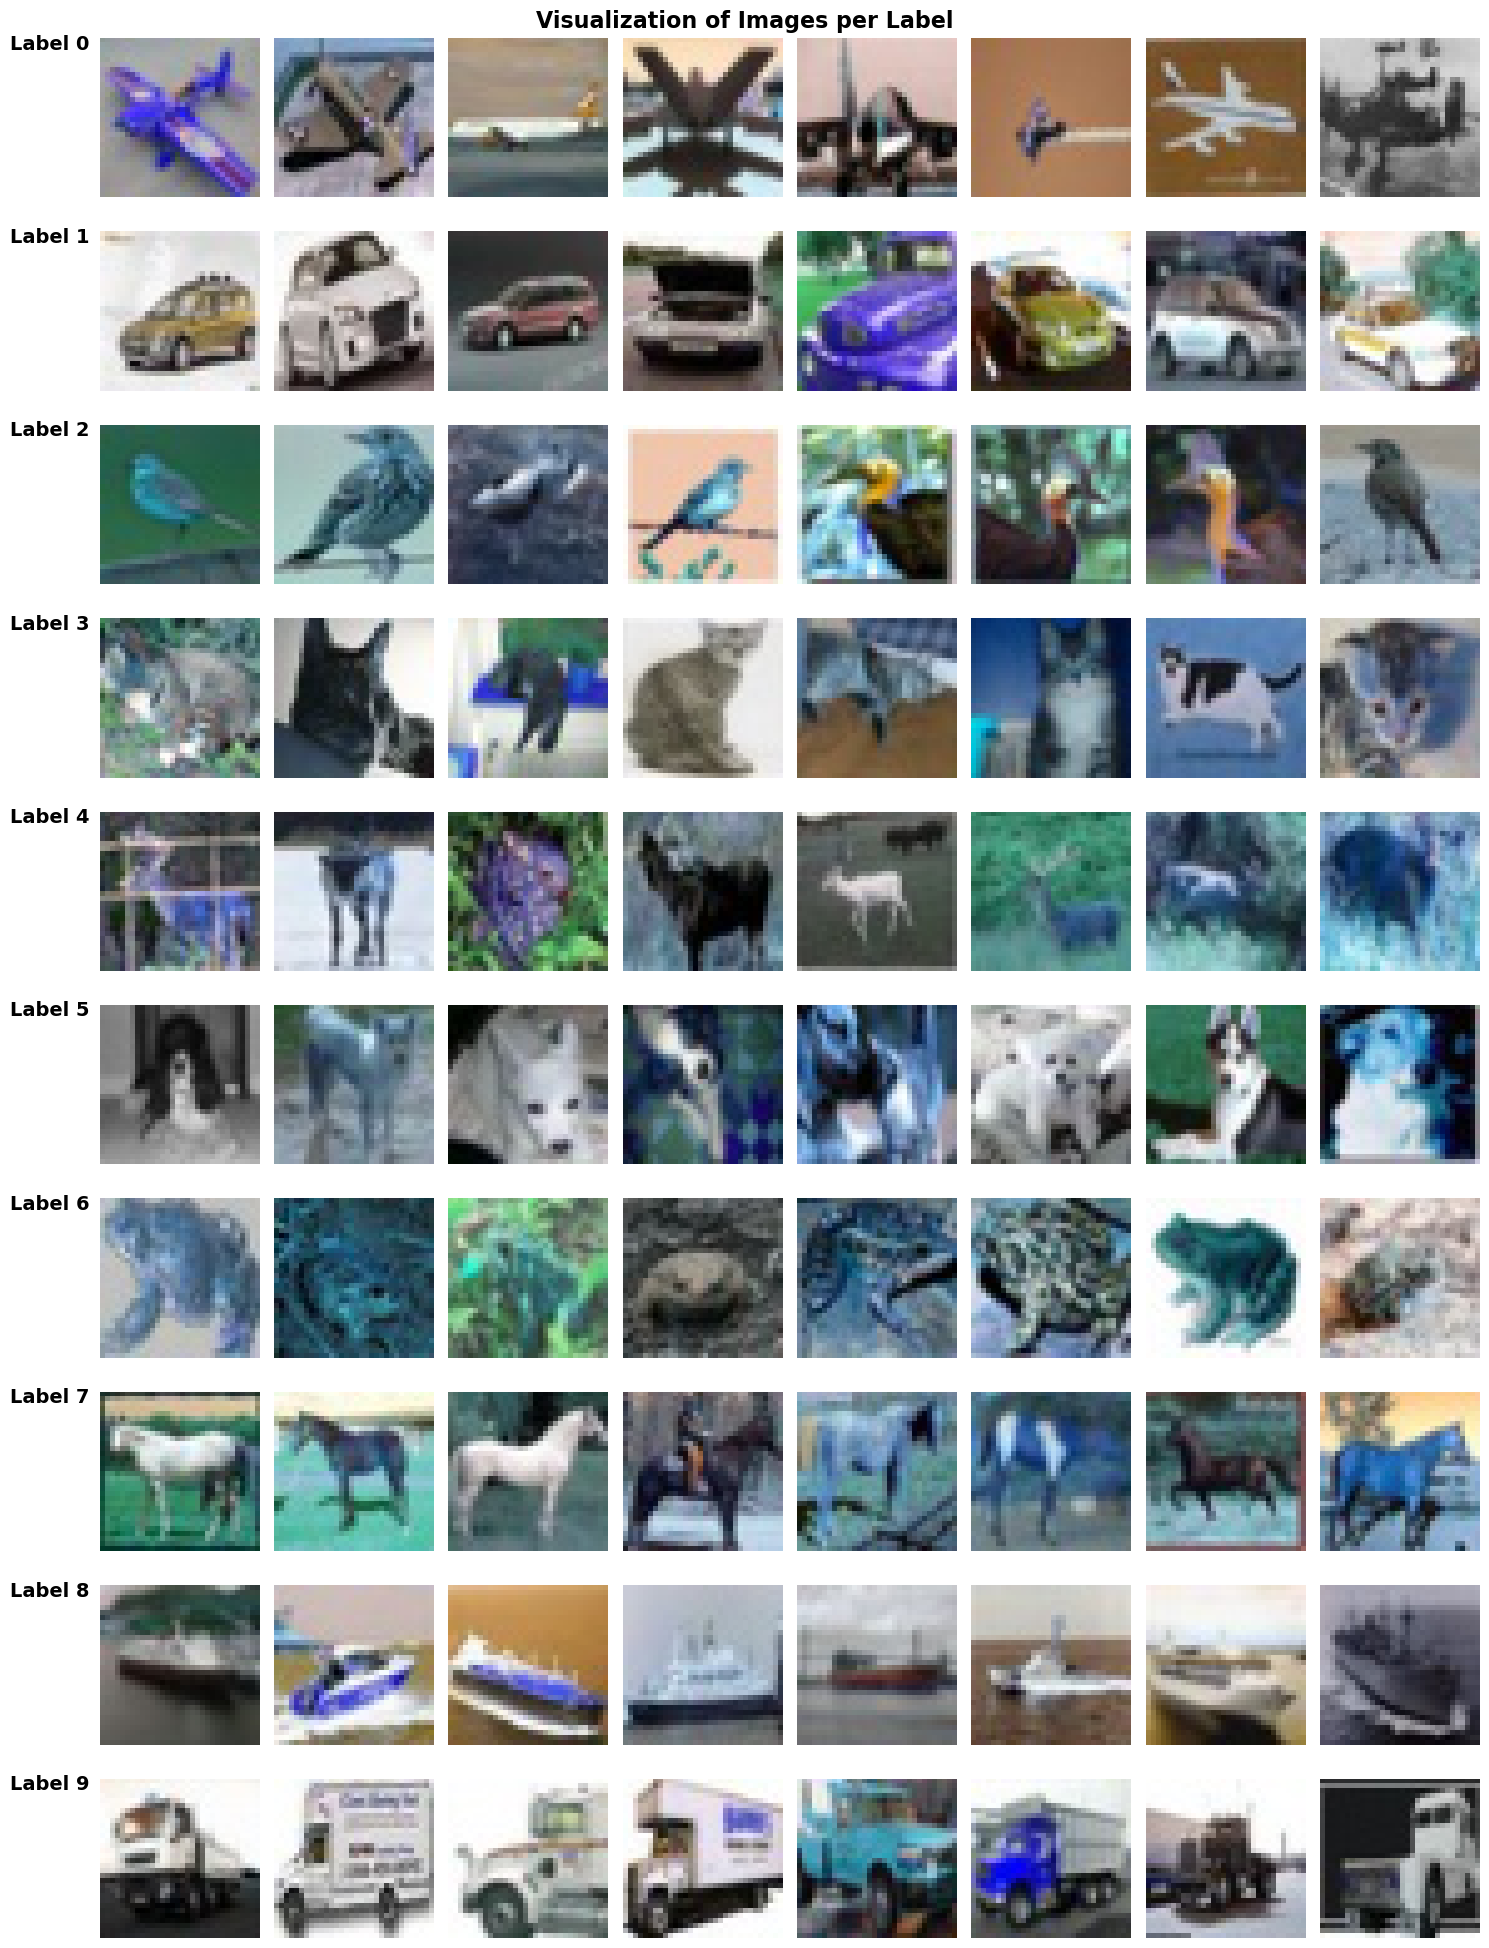

In [39]:
def visualize_images_by_label(img_dir, data, y, num_images=8):
    unique_labels = np.unique(y)  # Get all unique labels
    num_labels = len(unique_labels)  # Number of labels

    # Create a grid layout
    fig, axes = plt.subplots(num_labels, num_images, figsize=(15, num_labels * 2))
    fig.subplots_adjust(top=0.95)  # Adjust the top margin for the title
    fig.suptitle("Visualization of Images per Label", fontsize=16, fontweight='bold')  # Add title above the grid

    for i, label in enumerate(unique_labels):
        # Get indices corresponding to the current label
        indices = np.where(y == label)[0]
        # Randomly select num_images indices
        selected_indices = np.random.choice(indices, size=min(num_images, len(indices)), replace=False)

        for j, idx in enumerate(selected_indices):
            # Get the image path
            img_path = os.path.join(img_dir, data.iloc[idx, 0])
            # Open the image
            img = Image.open(img_path)

            # Display the image
            ax = axes[i, j] if num_labels > 1 else axes[j]  # Handle single-row case
            ax.imshow(img)
            ax.axis("off")  # Hide axes

        # Add label annotation to the first column of each row
        axes[i, 0].annotate(
            f"Label {label}",
            xy=(0, 0.5),
            xytext=(-axes[i, 0].yaxis.labelpad - 5, 0),
            textcoords="offset points",
            ha="right",
            va="center",
            fontsize=14,
            fontweight='bold',
            rotation=0,
        )

    plt.tight_layout()
    plt.show()

visualize_images_by_label(img_dir, data_train, y_train)



### Data Augmentation

In [40]:
import numpy as np
from PIL import Image, ImageEnhance
import random

def random_crop(image, crop_size):
    """
    Randomly crop the image to the specified size.

    Parameters:
        image (PIL.Image): Input image.
        crop_size (int): Size of the cropped image.

    Returns:
        PIL.Image: Cropped image.
    """
    width, height = image.size
    left = random.randint(0, width - crop_size)
    upper = random.randint(0, height - crop_size)
    right = left + crop_size
    lower = upper + crop_size
    return image.crop((left, upper, right, lower))

def random_rotation(image, max_angle=18):
    """
    Randomly rotate the image within a specified angle range.

    Parameters:
        image (PIL.Image): Input image.
        max_angle (int): Maximum rotation angle in degrees.

    Returns:
        PIL.Image: Rotated image.
    """
    angle = random.randint(-max_angle, max_angle)
    return image.rotate(angle)

def color_jitter(image, brightness=0.2, contrast=0.2, color=0.2):
    """
    Apply random color jittering to the image.

    Parameters:
        image (PIL.Image): Input image.
        brightness (float): Brightness adjustment factor range (e.g., 0.2 means [0.8, 1.2]).
        contrast (float): Contrast adjustment factor range.
        color (float): Color adjustment factor range.

    Returns:
        PIL.Image: Color-jittered image.
    """
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    factor = random.uniform(1 - brightness, 1 + brightness)
    image = enhancer.enhance(factor)

    # Adjust contrast
    enhancer = ImageEnhance.Contrast(image)
    factor = random.uniform(1 - contrast, 1 + contrast)
    image = enhancer.enhance(factor)

    # Adjust color
    enhancer = ImageEnhance.Color(image)
    factor = random.uniform(1 - color, 1 + color)
    image = enhancer.enhance(factor)

    return image

def aug_data(X, y, seed=None):
    """
    Augment the data by applying random cropping, random rotation, horizontal flipping, and color jittering.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    X_aug = []
    y_aug = []

    for i in range(len(X)):
        # Reshape to original image shape (H, W, C)
        img = X[i].reshape(32, 32, 3)
        label = y[i]

        # Convert to PIL Image for easier augmentation
        pil_img = Image.fromarray(img)

        # Append original image
        X_aug.append(np.array(pil_img).flatten())
        y_aug.append(label)
        # plt.imshow(pil_img)
        # plt.savefig(f"original_{i}.png")
        # plt.show()

        # Apply augmentations
        # Horizontal flip
        flipped_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
        # plt.imshow(flipped_img)
        # plt.savefig(f"flipped_{i}.png")
        # plt.show()
        X_aug.append(np.array(flipped_img).flatten())
        y_aug.append(label)

        # Random crop
        if random.random() < 0.1:
            crop_size = random.randint(24, 32)  # Random crop size between 24x24 and 32x32
            cropped_img = random_crop(pil_img, crop_size).resize((32, 32))
            # plt.imshow(cropped_img)
            # plt.savefig(f"cropped_{i}.png")
            # plt.show()
            X_aug.append(np.array(cropped_img).flatten())
            y_aug.append(label)

        # Random rotation
        if random.random() < 0.1:
            rotated_img = random_rotation(pil_img).resize((32, 32))
            # plt.imshow(rotated_img)
            # plt.savefig(f"rotated_{i}.png")
            # plt.show()
            X_aug.append(np.array(rotated_img).flatten())
            y_aug.append(label)

        # Color jittering
        if random.random() < 0.1:
            jittered_img = color_jitter(pil_img)
            # plt.imshow(jittered_img)
            # plt.savefig(f"jittered_{i}.png")
            # plt.show()
            X_aug.append(np.array(jittered_img).flatten())
            y_aug.append(label)

    return np.array(X_aug), np.array(y_aug)

# # Example usage
# X_train_aug, y_train_aug = aug_data(X_train, y_train, SEED)

### Test Augmentation

In [41]:
X_tt = X_train[0:2]
y_tt = y_train[0:2]
X_tt_aug, y_tt_aug = aug_data(X_tt, y_tt, SEED)

### Data after augmentation

In [42]:
X_train_aug, y_train_aug = aug_data(X_train, y_train, SEED)
print("Augmented training set shape: ", X_train_aug.shape)
print("Augmented training set labels shape: ", y_train_aug.shape)
# Count the labels
count_labels = np.unique(y_train_aug, return_counts=True)
# Create DataFrame
label_counts_df = pd.DataFrame({
    "Label": count_labels[0],
    "Count": count_labels[1]
}).set_index("Label")
# Print DataFrame
print("Count of each label in augmented training set:")
print(label_counts_df)

Augmented training set shape:  (115017, 3072)
Augmented training set labels shape:  (115017,)
Count of each label in augmented training set:
       Count
Label       
0      11603
1      11560
2      11570
3      11470
4      11425
5      11457
6      11477
7      11494
8      11494
9      11467
